In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import os
import mpld3
import umap
import sklearn
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances

%matplotlib inline 
mpld3.enable_notebook()

def load_data(directory):
    data = []
    for file in os.listdir(directory):
        data.append(np.load(directory+"/"+file))
    data = np.array(data)
    return data

weird_points = [1781, 536, 1145, 533, 1720, 1328, 1156, 722, 904, 360, 124, 842, 1859, 2496, 392, 1038, 947, 2322, 156, 2138, 193, 2140, 572, 1414]
def plot_lc(emedded_mat, title, outliers=None, baseline_outliers=weird_points, save_plot=True):
    x = emedded_mat[:, 0]
    y = emedded_mat[:, 1]
    fig, ax = plt.subplots(subplot_kw=dict(axisbg='#EEEEEE'))
    ax.set_xlabel('feature 1')
    ax.set_ylabel('feature 2')
    N = len(x)
    hehe = []
    s = []
    shapes = []
    for i in range(N):
        if i == 1156:
            hehe.append('r')
            s.append(80)
        if i in baseline_outliers:
            hehe.append('g')
            s.append(30)
            shapes.append("x")
        elif i in outliers:
            hehe.append('b')
            s.append(20)
            shapes.append("+") 
        else:
            hehe.append("#660066")
            s.append(1)
            shapes.append(".")
        
    hehe = np.array(hehe)
    s = np.array(s)
    
    scatter = ax.scatter(x,
                         y,
                         c=hehe,
                         s=s,
                         alpha=0.3,
                         zorder=10)
    ax.grid(color='white', linestyle='solid', zorder=0)

    ax.set_title(title, size=15)
    
    if save_plot:
        plt.savefig("final_images/" + str(title) +".ps", dpi=1500)

    labels = ['point {0}'.format(i + 1) for i in range(N)]
    tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
    mpld3.plugins.connect(fig, tooltip)
    
kdata = np.load('KeplerSampleFullQ.npy',encoding='bytes')
data = load_data("true_points")
reshaped_data = data.reshape(2500, 784)

def real_plot(num):
    x = kdata[num][0]
    y = kdata[num][1]
    y_err = kdata[num][2]
    plt.errorbar(x, y, yerr=y_err,fmt=".")
    
    plt.show()
def find_outliers(distances, metric='min', name="test", show_outliers=True, cutoff=3, limit=10, title=None, savefig=True):
    if metric == 'average':
        distribution = np.mean(distances, axis=1)
        average = np.mean(distribution)
        std = np.std(distribution)
        normalized = np.apply_along_axis(lambda x: (x-average)/std, 0, distribution)
        if title is None:
            plt.title("mean distance distribution for embedding: " + name)
        else:
            plt.title(title)
        plt.hist(normalized, bins=100)
        if savefig:
            plt.ylabel('Frequency')
            plt.xlabel('Normalized Nearest Neighbor Distance')
            plt.savefig("final_images/"+title + ".ps", dpi=100)
        plt.show()
        outliers = [i for i, _ in enumerate(normalized) if normalized[i] > cutoff]
        if show_outliers:
            count = 0
            for i in outliers:
                count += 1
                if count > limit:
                    break
                plt.title("outlier " + str(i) + " for embeddings: " + name)
                real_plot(i)
                print normalized[i]
        return outliers
    elif metric == 'min':
        distribution = []
        for i, _ in enumerate(distances):
            min_elem = np.min(np.concatenate((distances[i,:i], distances[i, i+1:]), axis=None))
            distribution.append(min_elem)
        distribution = np.array(distribution)
        average = np.mean(distribution)
        std = np.std(distribution)
        normalized = np.apply_along_axis(lambda x: (x-average)/std, 0, distribution)
        if title is None:
            plt.title("mean distance distribution for embedding: " + name)
        else:
            plt.title(title)
        plt.hist(normalized, bins=100)
        if savefig:
            plt.ylabel('Frequency')
            plt.xlabel('Normalized Nearest Neighbor Distance')
            plt.savefig("final_images/" + title + ".ps", dpi=100)
        plt.show()
        outliers = [i for i, _ in enumerate(normalized) if normalized[i] > cutoff]
        if show_outliers:
            count = 0
            for i in outliers:
                count += 1
                if count > limit:
                    break
                plt.title("outlier " + str(i) + " for embeddings: " + name)
                real_plot(i)
                print normalized[i]
        return outliers

OSError: [Errno 2] No such file or directory: 'true_points'

In [2]:
from sklearn.decomposition import PCA

# TSNE STUFF
p = 120
ee = 12
lr = 100

# UMAP 
neighbors = 70
min_dist = 1.0


pca_model = PCA(n_components=30)
pca_embeddings = pca_model.fit_transform(reshaped_data)

pca_model_2 = PCA(n_components=2)
pca_embeddings_2 = pca_model.fit_transform(reshaped_data)

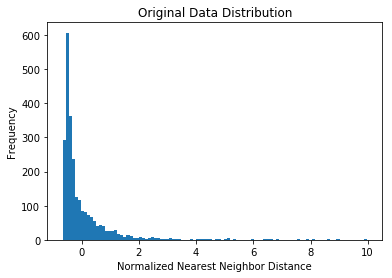

In [3]:
# original distribution
original_embeddings = pairwise_distances(reshaped_data)
outliers = find_outliers(original_embeddings, title="Original Data Distribution", show_outliers=False)

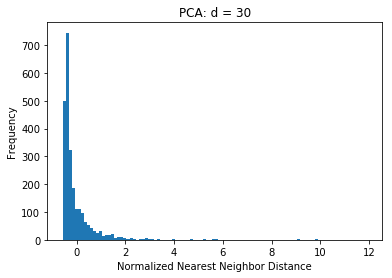

In [4]:
# pca embedding
pca_distances = pairwise_distances(pca_embeddings)
outliers = find_outliers(pca_distances, title="PCA: d = 30", limit=0)

In [5]:
# tsne from pca embeddings
tsne_model = TSNE(n_components=2, perplexity=p, early_exaggeration=ee, learning_rate=lr)
tsne_embeddings_pca = tsne_model.fit_transform(pca_embeddings)
print tsne_model.kl_divergence_

tsne_distances = pairwise_distances(tsne_embeddings_pca)

0.235609263182


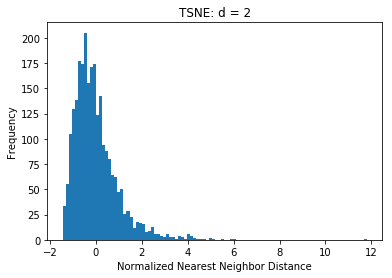

[150, 1117, 1180, 1277, 1720, 2282]


In [9]:
outliers = find_outliers(tsne_distances, title="TSNE: d = 2", limit=0, cutoff=5)
print outliers

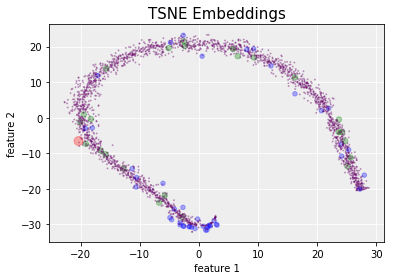

In [8]:
plot_lc(tsne_embeddings_pca, "TSNE Embeddings", outliers=outliers)

In [10]:
# same thing but for umap
neighbors = 120
min_dist = 1.0
model_umap = umap.UMAP(n_neighbors=neighbors, min_dist=min_dist)
embeddings_umap_pca = model_umap.fit_transform(pca_embeddings)

umap_distances = pairwise_distances(embeddings_umap_pca)
# outliers = find_outliers(umap_distances, name="UMAP PCA 30 to 2", limit=0)

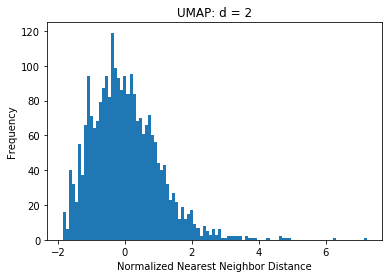

[362, 388, 538, 590, 828, 1496, 1749, 2282]


In [115]:
outliers = find_outliers(umap_distances, title="UMAP: d = 2", limit=0, cutoff=4)
print outliers

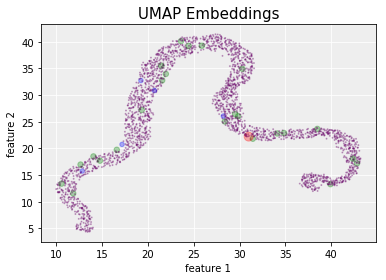

In [11]:
plot_lc(embeddings_umap_pca, "UMAP Embeddings", outliers=outliers)

In [4]:
def create_outliers_plot(outliers, show_error=False):
#     fig, ax = plt.subplots(nrows=3, ncols=3)
    f, axarr = plt.subplots(3, 3)
#     plt.xlabel("time")
#     f.set_size_inches(18.5, 10.5)
    row = 0
    for i, outlier in enumerate(outliers):
        col = i % 3
        if col == 0:
            row += 1
        
        print "ON OUTLIER " + str(outlier)
        x = kdata[outlier][0]
        y = kdata[outlier][1]
        y_err = kdata[outlier][2]
        ar_x = row - 1
        ar_y = col
        axarr[ar_x, ar_y].set_title(outlier)
        axarr[ar_x, ar_y].set_xticks([])
        axarr[ar_x, ar_y].set_yticks([])
        if show_error:
            axarr[ar_x, ar_y].errorbar(x, y, yerr=y_err,fmt=".")
        else:
            axarr[ar_x, ar_y].plot(x, y)
            
    # DO MANUAL STUFF HERE

#     axarr[2, 1].set_visible(False)
#     axarr[2,2].set_visible(False)
    
    plt.tight_layout()
    plt.savefig("final_images/UMAP_outliers.ps", dpi=100)
    plt.close()
        
outliers= [112, 934, 1132, 1317, 1347, 1552, 1960, 2005, 2344]
create_outliers_plot(outliers)

ON OUTLIER 112
ON OUTLIER 934
ON OUTLIER 1132
ON OUTLIER 1317
ON OUTLIER 1347
ON OUTLIER 1552
ON OUTLIER 1960
ON OUTLIER 2005
ON OUTLIER 2344


In [78]:
row = 0
for i in range(9):
    col = i % 3
    if col == 0:
        row += 1

    print str(row-1)+ " " + str(col)
    
print "HEHE"
row = 0
for i in range(9):
    col = i % 3
    if col == 0:
        row += 1

    print str(row-1)+ " " + str(col)

0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2
HEHE
0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2
